# Data Analysis for GaitWay Priliminary Data Collection Phase

In this notebook, we conduct exploratory data analysis to investigate various perspectives we can take to look at the data collected during the priliminary data collection using the GaitWay setup.

In [1]:
import sys
if '/Users/adelardalan/Work/QianLab/autism/py_wholebodymovement/' not in sys.path:
    sys.path.append('/Users/adelardalan/Work/QianLab/autism/py_wholebodymovement/')

import numpy as np
from scipy import interpolate
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt

import py_wholebodymovement as wbm

First, we load the data (ported and preprocessed from the MySQL database table `gaitway_db.captureddata`) from a zip file into the pandas dataframe `captureddata_df`'

In [2]:
%%time

captureddata_df = pd.read_csv('../data/captureddata_1.zip', compression='infer')

user_ids    = captureddata_df.UserID.unique()
movements   = captureddata_df.MovementName.unique()
joint_names = wbm.predefined_schemas._JOINT_NAMES_3

CPU times: user 19 s, sys: 1.18 s, total: 20.2 s
Wall time: 20.2 s


The loaded dataset contains {{ captureddata_df.shape[0] }} rows each corresponding to a frame. There are {{ len(user_ids) }} participants (also referred to as users) in this dataset performing the following movements during various sessions:

<b>{{ '<br />'.join(sorted(list(movements))) }}</b>

In this notebook, we will only analyze the data for participants `PFLXXX` (dropping some of them too; see below).

The dataset has {{ captureddata_df.shape[1] }} columns, consisting of participant ID, session number, movement name, time stamp, and $(x,y,z)$ coordinates of the {{ len(joint_names) }} points of interest (POIs) on the participants' bodies at each frame performing the moves:

<b>{{ "<br />".join(joint_names) }}</b>

Here are the first few rows of the dataset:

{{ display(captureddata_df.head()) }}

Here is a sample frame projected on the 2D $xy$ plane:

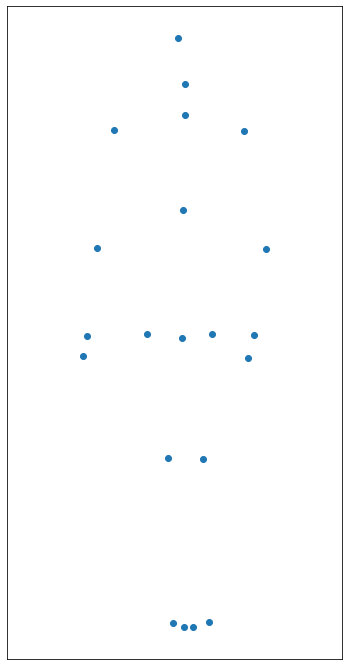

In [3]:
user_id        = 'PFL007'
session_number = 1
movement_name  = 'Idle'
frame_no       = 200

fig = plt.figure(figsize=(6,12))
row = captureddata_df[(captureddata_df.UserID == user_id) & 
                      (captureddata_df.SessionNumber == session_number) &
                      (captureddata_df.MovementName == movement_name)
                     ].iloc[frame_no,:]
xx = row[[cnm for cnm in captureddata_df.columns if '_x' in cnm]]
yy = row[[cnm for cnm in captureddata_df.columns if '_y' in cnm]]
plt.scatter(xx, yy,)
plt.xlim(min(xx)-.1, max(xx)+.1)
plt.ylim(min(yy)-.1, max(yy)+.1)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.axis('equal')
plt.show()

Next, we load the participants' demographic data:

In [4]:
participant_demographics = pd.read_csv("../data/BOT_dataset_latest_DH_20200428.csv", index_col='Participant_ID')
participant_demographics

,AGE,GENDER,HEIGHT,WEIGHT,BOT_grossraw_pre,BOT_totalraw_pre,BOT_grossraw_post,BOT_totalraw_post,Flanker_rawpre,Flanker_rawpost,...,DSM_hyper,DSM_cond,DSM_opp,Conners_Global_interp,Conners_inattent_interp,Conners_hyperact_interp,Conners_learn_prob_interp,Conners_exec_prob_interp,Conners_defiance_interp,Conners_peer_rel_interp
Participant_ID,,,,,,,,,,,,,,,,,,,,,
PFL001,13,1,177.0,64.2,42,69,45,71,20.0,19,...,23,1,3,5,5,5,3,5,3,5
PFL002,14,1,156.5,51.9,50,75,50,76,NaN,19,...,22,1,9,5,2,5,2,2,2,5
PFL003,17,1,165.0,73.7,43,70,43,68,19.0,20,...,6,1,6,4,2,4,2,2,2,3
PFL004,17,1,191.0,95.6,43,64,40,66,20.0,20,...,9,2,11,5,5,5,5,4,2,5
PFL005,14,1,151.0,35.2,45,65,40,67,20.0,20,...,1,1,1,2,4,4,5,2,2,5
PFL006,10,1,72.8,164.5,29,55,35,61,20.0,20,...,24,3,10,5,5,5,4,4,5,5
PFL007,16,1,153.0,49.5,42,69,47,73,20.0,20,...,0,0,0,2,2,2,2,2,2,4
PFL008,17,2,179.0,89.0,46,72,47,73,20.0,20,...,14,4,6,4,3,5,3,2,4,5
PFL010,11,1,175.0,67.0,47,74,46,73,20.0,20,...,8,0,1,2,5,3,5,5,2,2


We note that the participants are not gender balanced and should consider this in all of our analysis and possible conclusions.

## Breaking Down the Sessions to Individual Moves

Each session consists of a participant performing a sequence of moves and in this analysis, we wish to look at the data at the single _move_ level; that is, we want to look at various repetitions of a movement (e.g. jumping jacks) during a session separately. The following scrips creates a copy `captureddata_df_augmented` of the original dataset `captureddata_df` and change the movement names to unique move names of the format `<MOVE>@<FRAME>` where `MOVE` is one of the {{ len(movements) }} possible movements and `FRAME` is the ending frame of the corresponding move. For now we focus on the first few sessions only, determined by the value of `max_sessions` variable.

In [5]:
%%time

max_sessions   = 6

unique_user_ids        = [gg for gg in captureddata_df.UserID.unique() if 'PFL' in gg]
unique_user_ids        = sorted(unique_user_ids)
unique_movement_names  = captureddata_df.MovementName.unique()
unique_session_numbers = captureddata_df.SessionNumber.unique()

captureddata_df_augmented = pd.DataFrame(columns=captureddata_df.columns)

for user_id_idx in range(len(unique_user_ids)):
    user_id = unique_user_ids[user_id_idx]
    print("User %s"%user_id)
    
    user_movement_session_numbers = sorted(captureddata_df[(captureddata_df.UserID==user_id) #& 
                                                   ].SessionNumber.unique())[:max_sessions]

    user_movement_session_numbers.sort()
    for session_number_inx in range(len(user_movement_session_numbers)):
        session_number = user_movement_session_numbers[session_number_inx]
        print("\tSessions %d"%session_number)
        
        session_data = captureddata_df[(captureddata_df.UserID == user_id) & 
                              (captureddata_df.SessionNumber == session_number) #&
                             ]
        if session_data.shape[0] == 0:
            continue

        captureddata_df_augmented = pd.concat([captureddata_df_augmented, session_data], axis=0)
        
        latest_movement_inx       = np.inf
        latest_movement_start_inx = session_data.index[0]
        latest_movement           = session_data.loc[latest_movement_start_inx, :].MovementName
        
        has_data = True
        
        while has_data:
            session_data_slice            = session_data.loc[latest_movement_start_inx:, :]
            
            latest_movement_start_inx     = session_data_slice.MovementName.ne(latest_movement).idxmax()
            
            if latest_movement_start_inx == session_data_slice.index[0]:
                has_data = False
                latest_movement_start_inx = session_data_slice.index[-1]

            captureddata_df_augmented.loc[session_data_slice.index[0]:latest_movement_start_inx, 'MovementName'
                                          ] = latest_movement+'@%d'%latest_movement_start_inx

            latest_movement               = session_data.loc[latest_movement_start_inx, :].MovementName

            print("\t\tMove %s at %d"%(latest_movement, latest_movement_start_inx))

User PFL001
	Sessions 1
		Move Walk at 1549440
		Move OLB at 1549500
		Move TheShoot at 1549620
		Move Walk at 1549680
		Move Idle at 1549740
		Move OLB at 1550220
		Move Idle at 1550400
		Move OLB at 1550460
		Move JumpBack at 1550820
		Move OLB at 1550880
		Move Walk at 1550940
		Move Idle at 1551000
		Move JumpingJack at 1551120
		Move Idle at 1551180
		Move JumpingJack at 1551420
		Move TouchingNose at 1551480
		Move JumpingJack at 1551660
		Move Idle at 1551960
		Move JumpRight at 1552020
		Move Idle at 1552080
		Move OLB at 1552440
		Move Idle at 1552500
		Move OLB at 1552920
		Move Idle at 1553400
		Move OLB at 1553460
		Move Idle at 1553820
		Move JumpForward at 1554180
		Move Idle at 1554240
		Move JumpForward at 1554300
		Move Walk at 1554360
		Move TheShoot at 1554480
		Move Walk at 1554540
		Move Idle at 1554600
		Move OLB at 1554660
		Move Idle at 1554840
		Move JumpBack at 1555860
		Move Idle at 1555920
		Move Walk at 1555980
		Move OLB at 1556040
		Move TheShoot at 15561

		Move Idle at 145319
	Sessions 4
		Move Idle at 303179
	Sessions 5
		Move Idle at 546419
	Sessions 6
		Move OLB at 944940
		Move TheShoot at 945000
		Move JumpingJack at 945120
		Move TheShoot at 945180
		Move JumpingJack at 945240
		Move Walk at 945360
		Move OLB at 945420
		Move Idle at 945480
		Move OLB at 945600
		Move Idle at 945660
		Move OLB at 945780
		Move TheShoot at 945840
		Move JumpForward at 945900
		Move TheShoot at 945960
		Move Idle at 946020
		Move OLB at 946080
		Move Idle at 946200
		Move OLB at 946260
		Move Idle at 946380
		Move OLB at 946440
		Move Idle at 946560
		Move OLB at 946620
		Move TheShoot at 946740
		Move Idle at 946800
		Move OLB at 946860
		Move TheShoot at 946920
		Move JumpingJack at 947040
		Move TheShoot at 947100
		Move JumpingJack at 947160
		Move OLB at 947280
		Move Idle at 947340
		Move OLB at 947400
		Move JumpingJack at 947460
		Move JumpRight at 947580
		Move TheShoot at 947640
		Move Idle at 947700
		Move OLB at 947760
		Move Idle at 94

		Move TheShoot at 1262340
		Move OLB at 1262460
		Move Idle at 1262580
		Move TheShoot at 1262640
		Move JumpingJack at 1262880
		Move TheShoot at 1263000
		Move OLB at 1263060
		Move TheShoot at 1263120
		Move OLB at 1263420
		Move TheShoot at 1263540
		Move Idle at 1263660
		Move Idle at 1263959
User PFL003
	Sessions 1
		Move OLB at 1144680
		Move Idle at 1144800
		Move Walk at 1144860
		Move OLB at 1144920
		Move Idle at 1145340
		Move OLB at 1146060
		Move JumpingJack at 1146120
		Move TheShoot at 1146240
		Move Idle at 1146360
		Move OLB at 1146540
		Move Idle at 1146600
		Move OLB at 1146660
		Move Idle at 1146720
		Move TheShoot at 1146780
		Move Idle at 1146840
		Move JumpingJack at 1146960
		Move Idle at 1147020
		Move OLB at 1147080
		Move TheShoot at 1147200
		Move OLB at 1147260
		Move TheShoot at 1148160
		Move Idle at 1148280
		Move OLB at 1148340
		Move TheShoot at 1148580
		Move OLB at 1148640
		Move TheShoot at 1148760
		Move Idle at 1148820
		Move OLB at 1149000
		Mo

		Move Idle at 1714919
User PFL004
	Sessions 1
		Move OLB at 46320
		Move Idle at 46440
		Move TheShoot at 46740
		Move Idle at 46860
		Move OLB at 46920
		Move Idle at 46980
		Move OLB at 47220
		Move Idle at 47280
		Move JumpingJack at 47760
		Move Idle at 47820
		Move JumpingJack at 47880
		Move TheShoot at 47940
		Move OLB at 48000
		Move Idle at 48060
		Move JumpingJack at 48420
		Move Idle at 48900
		Move OLB at 49140
		Move Idle at 49620
		Move OLB at 49860
		Move Idle at 51000
		Move JumpLeft at 51060
		Move Walk at 51120
		Move OLB at 51180
		Move Walk at 51300
		Move JumpRight at 51360
		Move Walk at 51420
		Move OLB at 51480
		Move Idle at 52140
		Move Walk at 52320
		Move Idle at 52380
		Move OLB at 52500
		Move TheShoot at 52560
		Move OLB at 52620
		Move TheShoot at 52740
		Move OLB at 52800
		Move Walk at 52860
		Move JumpLeft at 52920
		Move TheShoot at 52980
		Move Idle at 53220
		Move TheShoot at 60420
		Move Idle at 60540
		Move TouchingNose at 60840
		Move Idle at 6

		Move TouchingNose at 606900
		Move JumpForward at 606960
		Move TheShoot at 607020
		Move TouchingNose at 607080
		Move TheShoot at 607200
		Move JumpingJack at 607380
		Move TheShoot at 607440
		Move Idle at 607560
		Move JumpLeft at 607680
		Move TheShoot at 607740
		Move Idle at 607800
		Move JumpRight at 607860
		Move Walk at 607920
		Move TheShoot at 607980
		Move OLB at 608040
		Move TheShoot at 608100
		Move TouchingNose at 608160
		Move TheShoot at 608220
		Move OLB at 608400
		Move Idle at 608460
		Move JumpRight at 608520
		Move TheShoot at 608580
		Move JumpingJack at 608700
		Move Idle at 608760
		Move TheShoot at 609060
		Move JumpForward at 609240
		Move Walk at 609300
		Move TheShoot at 609360
		Move OLB at 609420
		Move TheShoot at 609480
		Move Idle at 609540
		Move TheShoot at 609600
		Move Walk at 609720
		Move TheShoot at 609780
		Move Walk at 609840
		Move Idle at 609900
		Move TheShoot at 609960
		Move OLB at 610260
		Move JumpForward at 610320
		Move Walk at 61

		Move OLB at 1114860
		Move TheShoot at 1114980
		Move Idle at 1115040
		Move OLB at 1115160
		Move Idle at 1115280
		Move TheShoot at 1115340
		Move OLB at 1115400
		Move Idle at 1115580
		Move OLB at 1115640
		Move Idle at 1115700
		Move OLB at 1115760
		Move Idle at 1115940
		Move OLB at 1116000
		Move Idle at 1116300
		Move OLB at 1116360
		Move Idle at 1116420
		Move OLB at 1116540
		Move Idle at 1116600
		Move OLB at 1116720
		Move Idle at 1116900
		Move TheShoot at 1116960
		Move OLB at 1117020
		Move TheShoot at 1117080
		Move OLB at 1117140
		Move TheShoot at 1117260
		Move Idle at 1117320
		Move OLB at 1117500
		Move Idle at 1117680
		Move TheShoot at 1117740
		Move OLB at 1117800
		Move TheShoot at 1118280
		Move Idle at 1118400
		Move OLB at 1118700
		Move TheShoot at 1118940
		Move OLB at 1119060
		Move Idle at 1119120
		Move OLB at 1119180
		Move TheShoot at 1119240
		Move Idle at 1119420
		Move OLB at 1128000
		Move TheShoot at 1128120
		Move Idle at 1128180
		Move OLB 

		Move JumpingJack at 2049660
		Move Idle at 2049720
		Move TheShoot at 2049780
		Move JumpingJack at 2049840
		Move TheShoot at 2049900
		Move JumpingJack at 2050020
		Move OLB at 2050080
		Move Idle at 2050260
		Move TheShoot at 2050320
		Move JumpingJack at 2050380
		Move Idle at 2050440
		Move OLB at 2050620
		Move Idle at 2050680
		Move TheShoot at 2050800
		Move Idle at 2050860
		Move JumpingJack at 2051340
		Move Idle at 2051400
		Move TheShoot at 2051520
		Move OLB at 2051580
		Move Walk at 2051640
		Move OLB at 2051700
		Move Idle at 2051820
		Move OLB at 2051880
		Move TheShoot at 2051940
		Move TouchingNose at 2052240
		Move TheShoot at 2052360
		Move TouchingNose at 2052480
		Move TheShoot at 2052600
		Move Idle at 2052660
		Move OLB at 2052720
		Move Idle at 2052840
		Move TheShoot at 2052900
		Move OLB at 2052960
		Move Idle at 2053080
		Move OLB at 2053140
		Move Walk at 2053200
		Move Idle at 2053260
		Move TheShoot at 2053320
		Move Idle at 2053380
		Move OLB at 205350

		Move JumpingJack at 1322100
		Move Idle at 1322160
		Move OLB at 1322220
		Move Walk at 1322280
		Move Idle at 1322340
		Move JumpingJack at 1322400
		Move JumpRight at 1322460
		Move JumpingJack at 1322520
		Move Idle at 1322940
		Move JumpRight at 1323720
		Move Idle at 1323840
		Move JumpingJack at 1324080
		Move TouchingNose at 1324140
		Move JumpingJack at 1324200
		Move Idle at 1324260
		Move JumpRight at 1324320
		Move JumpingJack at 1324560
		Move TouchingNose at 1324620
		Move JumpingJack at 1324740
		Move TouchingNose at 1324860
		Move Idle at 1325040
		Move OLB at 1325100
		Move Idle at 1325160
		Move OLB at 1325280
		Move Idle at 1325340
		Move Walk at 1325460
		Move Idle at 1325520
		Move JumpRight at 1325580
		Move JumpingJack at 1325640
		Move JumpRight at 1325700
		Move Idle at 1325760
		Move JumpRight at 1325820
		Move JumpBack at 1326000
		Move JumpRight at 1326060
		Move TheShoot at 1326120
		Move JumpingJack at 1326180
		Move TouchingNose at 1326240
		Move Idle at

		Move Idle at 2465880
		Move OLB at 2465940
		Move TheShoot at 2466000
		Move Idle at 2466060
		Move TheShoot at 2466180
		Move Idle at 2466240
		Move TouchingNose at 2466420
		Move Idle at 2466660
		Move TheShoot at 2466780
		Move Idle at 2466840
		Move TheShoot at 2466900
		Move JumpingJack at 2466960
		Move TouchingNose at 2467020
		Move Idle at 2467200
		Move OLB at 2467260
		Move TheShoot at 2467320
		Move Idle at 2467380
		Move OLB at 2467440
		Move Idle at 2467500
		Move OLB at 2467560
		Move Idle at 2467620
		Move OLB at 2467860
		Move Idle at 2467920
		Move TheShoot at 2467980
		Move JumpBack at 2468040
		Move JumpRight at 2468100
		Move JumpForward at 2468220
		Move OLB at 2468280
		Move TheShoot at 2468340
		Move JumpingJack at 2468400
		Move TheShoot at 2468460
		Move Idle at 2468580
		Move JumpingJack at 2469420
		Move TouchingNose at 2469540
		Move Idle at 2469900
		Move TheShoot at 2469960
		Move JumpBack at 2470020
		Move OLB at 2470140
		Move JumpingJack at 2470200
		

		Move Idle at 1337700
		Move JumpingJack at 1337760
		Move TheShoot at 1337820
		Move JumpingJack at 1337880
		Move TheShoot at 1338060
		Move JumpingJack at 1338120
		Move Idle at 1338240
		Move JumpingJack at 1338420
		Move TheShoot at 1338900
		Move JumpingJack at 1338960
		Move OLB at 1339080
		Move JumpingJack at 1339140
		Move Idle at 1339440
		Move TheShoot at 1339800
		Move JumpingJack at 1339860
		Move Idle at 1339920
		Move TheShoot at 1340520
		Move Idle at 1340580
		Move JumpingJack at 1340820
		Move Idle at 1340880
		Move JumpingJack at 1341300
		Move Idle at 1341360
		Move JumpingJack at 1342020
		Move Idle at 1342080
		Move OLB at 1342800
		Move JumpForward at 1342860
		Move Idle at 1342920
		Move OLB at 1343280
		Move Idle at 1343340
		Move TheShoot at 1343520
		Move Idle at 1343580
		Move OLB at 1343640
		Move Idle at 1343700
		Move TheShoot at 1344540
		Move OLB at 1344600
		Move Idle at 1344660
		Move JumpForward at 1345440
		Move TheShoot at 1345500
		Move Idle at 

		Move JumpingJack at 2433480
		Move TheShoot at 2433540
		Move TouchingNose at 2433660
		Move JumpingJack at 2433720
		Move TheShoot at 2433840
		Move JumpingJack at 2433900
		Move Idle at 2434020
		Move TheShoot at 2451540
		Move Idle at 2451720
		Move TheShoot at 2451780
		Move Idle at 2451840
		Move TheShoot at 2452020
		Move Idle at 2452080
		Move TheShoot at 2452140
		Move Idle at 2452380
		Move TheShoot at 2452440
		Move Idle at 2452500
		Move JumpingJack at 2452860
		Move TouchingNose at 2452920
		Move Idle at 2452980
		Move TheShoot at 2453040
		Move OLB at 2453100
		Move JumpingJack at 2453160
		Move TheShoot at 2453220
		Move Idle at 2453340
		Move JumpingJack at 2453400
		Move TheShoot at 2453460
		Move TouchingNose at 2453520
		Move TheShoot at 2453760
		Move OLB at 2454000
		Move TouchingNose at 2454060
		Move Idle at 2454300
		Move OLB at 2454360
		Move Idle at 2454420
		Move OLB at 2454540
		Move JumpingJack at 2454720
		Move Idle at 2454840
		Move OLB at 2454960
		Move

		Move OLB at 1066800
		Move Idle at 1066920
		Move OLB at 1066980
		Move TheShoot at 1067220
		Move OLB at 1067280
		Move TheShoot at 1068000
		Move Idle at 1068060
		Move OLB at 1068120
		Move TheShoot at 1068660
		Move Idle at 1068780
		Move OLB at 1068840
		Move Idle at 1068960
		Move OLB at 1069080
		Move Idle at 1069620
		Move OLB at 1069680
		Move Idle at 1069800
		Move OLB at 1069860
		Move JumpRight at 1070400
		Move Idle at 1070460
		Move OLB at 1070520
		Move Idle at 1070580
		Move OLB at 1070640
		Move Idle at 1071840
		Move OLB at 1071900
		Move Idle at 1072080
		Move OLB at 1072140
		Move Idle at 1072260
		Move Idle at 1072379
	Sessions 2
		Move JumpingJack at 1079700
		Move Idle at 1079760
		Move TheShoot at 1081140
		Move TouchingNose at 1081200
		Move JumpingJack at 1081500
		Move Idle at 1081560
		Move Walk at 1081740
		Move Idle at 1081800
		Move OLB at 1082100
		Move Idle at 1082160
		Move TouchingNose at 1082460
		Move JumpingJack at 1082640
		Move Idle at 1082700


		Move OLB at 1781280
		Move Idle at 1781520
		Move JumpingJack at 1781580
		Move OLB at 1781640
		Move Idle at 1781700
		Move OLB at 1781760
		Move TheShoot at 1781880
		Move Idle at 1782000
		Move JumpingJack at 1782060
		Move TheShoot at 1782120
		Move JumpingJack at 1782180
		Move TheShoot at 1782240
		Move Idle at 1782300
		Move TheShoot at 1782420
		Move Idle at 1782480
		Move TheShoot at 1793940
		Move TouchingNose at 1794000
		Move JumpingJack at 1794120
		Move TouchingNose at 1794180
		Move TheShoot at 1794300
		Move OLB at 1794360
		Move TheShoot at 1794420
		Move Idle at 1794480
		Move TheShoot at 1794660
		Move OLB at 1794720
		Move Idle at 1794780
		Move OLB at 1794840
		Move Idle at 1794900
		Move JumpingJack at 1794960
		Move Idle at 1795020
		Move OLB at 1795080
		Move Idle at 1795140
		Move TheShoot at 1795200
		Move Idle at 1795260
		Move OLB at 1795380
		Move Idle at 1795560
		Move JumpingJack at 1795620
		Move Idle at 1795680
		Move TheShoot at 1795740
		Move Idle a

To see a sample of the moves and their length (in frames), we run the following script:

In [6]:
%%time

coordinate_columns = [col_prefix+coord for col_prefix in joint_names for coord in ['_x', '_y', '_z']]
counts_pivot_table_aug = captureddata_df_augmented.groupby(['UserID', 'SessionNumber', 'MovementName'], as_index=False).size().to_frame('count').reset_index()
counts_pivot_table_aug.head(20)

CPU times: user 191 ms, sys: 117 ms, total: 308 ms
Wall time: 312 ms


,UserID,SessionNumber,MovementName,count
0,PFL001,1,Idle@1549440,2940
1,PFL001,1,Idle@1550220,480
2,PFL001,1,Idle@1550460,60
3,PFL001,1,Idle@1551120,120
4,PFL001,1,Idle@1551420,240
5,PFL001,1,Idle@1552020,60
6,PFL001,1,Idle@1552440,360
7,PFL001,1,Idle@1552920,420
8,PFL001,1,Idle@1553460,60
9,PFL001,1,Idle@1554180,360


And here's a histogram of the non-`Idle` move lengths:

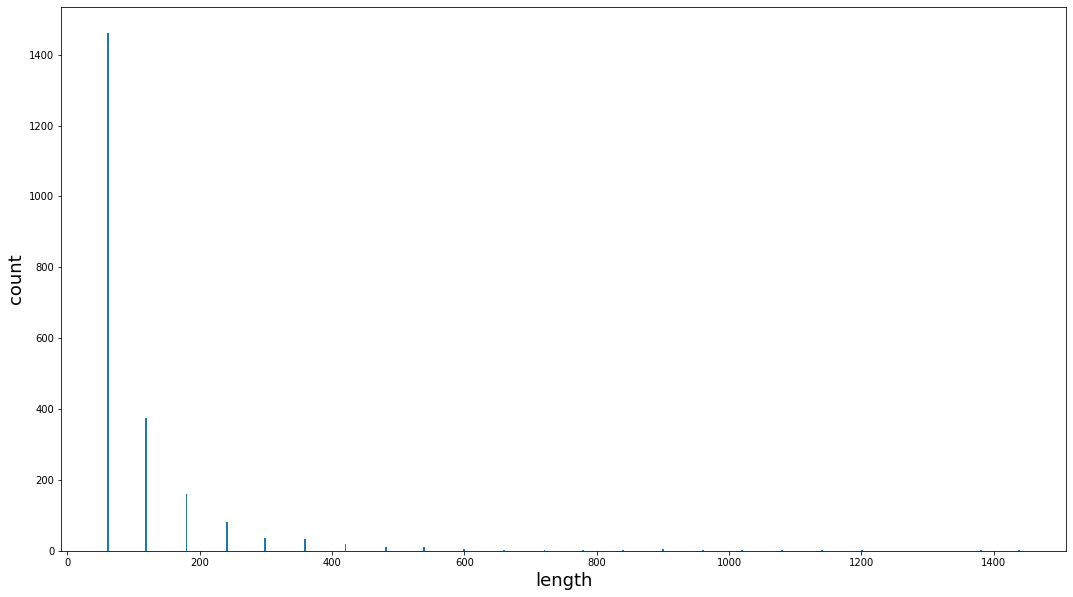

In [7]:
allcnts = counts_pivot_table_aug[(~counts_pivot_table_aug.MovementName.str.contains('Idle')) &
                                 (counts_pivot_table_aug.SessionNumber < 6)
                                ]['count'].values
plt.figure(figsize=(18,10))
plt.hist(allcnts, bins=500)
plt.xlabel('length', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.show()

## Denoising the Moves

Investigating the individual moves signals (see the blue plot below) we see that there are some high-frequency (HF) components present in the captured data that are physically unrealistic. These are artifacts of the data collection devices and procesdures which are not plausible in the context of human movement and need to be removed from the data. To this end, we use wavelet transforms through calling the `denoise_data` function to remove the HF artifacts of the data. Here is an example of the original signal (blue) and the denoised version (orange):

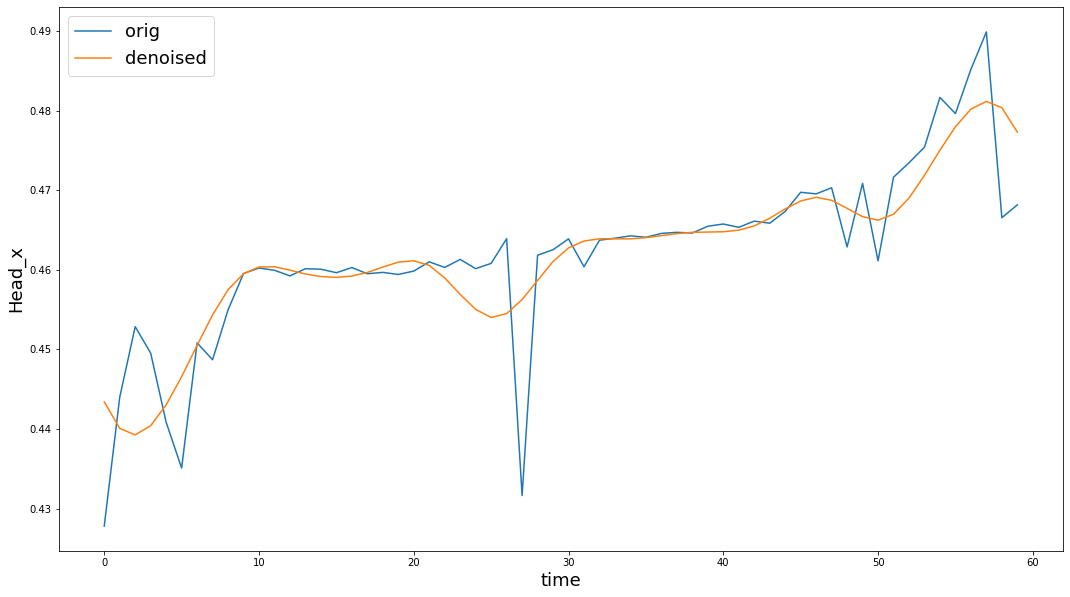

In [8]:
yy_orig = captureddata_df_augmented[captureddata_df_augmented.MovementName == 'JumpRight@2333400'].Head_x.values
yy = wbm.denoise_data(yy_orig, haarlevel=2, shrinking_factor=1)

plt.figure(figsize=(18,10))
plt.plot(yy_orig, label='orig')
plt.plot(yy, label='denoised')
plt.xlabel('time', fontsize=18)
plt.ylabel('Head_x', fontsize=18)
plt.legend(fontsize=18)
plt.show()

## Computing the Synchrony Measures of Articulated Figure Angles for Various Moves

We now use the data created above to analyze various summary statistics of moves and how they correlate with various demographics information. To do so, we go through the following steps:

1. For each move, we first use the $(x,y,z)$ coordinates of POIs to calculated various articulated figure angles for each frame. We do this by calling the function `calculate_3d_articulated_figure_angles` and specify the angles using the dictionary `_ARTICULATED_FIGURE_ANGLES_3`: <br/><br/>
<b> {{ print(str(wbm.predefined_schemas.\_ARTICULATED_FIGURE_ANGLES_3).replace("),", "),<br />").replace('"', '')) }} </b>
<br/><br/> Each entry in this dictionary is of the form `<angle_name>:(<T>,<U>,<S>,<WD>,<POS>)` where `angle_name` is the given name of the angle, and `T`, `U` and `S` are the names of the POIs which specify this angle as $\angle UTS$ (`<WD>` and `<POS>` are relvant only for 2D articulated figures; see documentation for details).

2. Next, we pick two of the angles `angle1` and `angle2` from the above articulated figure angles, denoise them using the procedure described before, and calculated various synchrony measures for them. Specifically, we calculate MARP, CRPSD [Meyns et. al.](https://doi.org/10.1016/j.ridd.2012.03.020) and PLV [Wang et. al.](https://doi.org/10.1109/IEMBS.2006.259673) and save them along with some of the demographics data in `sync_measures` table.

In [9]:
%%time

unique_user_ids        = [gg for gg in captureddata_df.UserID.unique() if 'PFL' in gg]
unique_user_ids        = sorted(unique_user_ids)
unique_movement_names  = captureddata_df.MovementName.unique()
unique_session_numbers = captureddata_df.SessionNumber.unique()

bar_colors = {
    'Normal': 'g',
    'Moderate': 'b',
    'Severe': 'r',
}

movement_name  = 'Walk'
max_sessions   = 6
angle1          = 'rshldr_theta'
angle2          = 'lhip_theta'

nrows, ncols = int(len(unique_user_ids)**.5)+1, int(len(unique_user_ids)**.5)
jj = 1

shrinking_factor = 1
sync_measures = pd.DataFrame(columns=['ParticipantID', 'BOT_totalraw_pre', 'BOT_grossraw_pre', 'AGE', 'HEIGHT', 'WEIGHT', 'MARP', 'CRPSD', 'PLV'])

miny, maxy = np.inf, -np.inf
for user_id_idx in range(len(unique_user_ids)):
    user_id = unique_user_ids[user_id_idx]
    if user_id not in participant_demographics.index:
        continue
    
    user_movement_first_session_number = sorted(captureddata_df[(captureddata_df.UserID==user_id) & 
                                                         (captureddata_df_augmented.MovementName.str.contains(movement_name))
                                                        ].SessionNumber.unique())[0]

    user_movement_session_trials = sorted(captureddata_df_augmented[(captureddata_df_augmented.UserID==user_id) &
                                                                    (captureddata_df_augmented.SessionNumber==user_movement_first_session_number) &
                                                                    (captureddata_df_augmented.MovementName.str.contains(movement_name))
                                                                   ].MovementName.unique())
    
    for trial_inx in range(len(user_movement_session_trials)):
        trial = user_movement_session_trials[trial_inx]
        
        session_data = captureddata_df_augmented[captureddata_df_augmented.MovementName == trial]
        if session_data.shape[0] == 0:
            continue
#         session_af_data = wbm.calculate_2d_articulated_figure_angles(session_data, 
#                                                                      angles=wbm.predefined_schemas._ARTICULATED_FIGURE_ANGLES_3,
#                                                                      x_suffix='_x', y_suffix='_y',
#                                                                     ).set_index(session_data.index)
        session_af_data = wbm.calculate_3d_articulated_figure_angles(session_data, 
                                                                     angles=wbm.predefined_schemas._ARTICULATED_FIGURE_ANGLES_3,
                                                                     x_suffix='_x', y_suffix='_y', z_suffix='_z',
                                                                    ).set_index(session_data.index)

        session_data = pd.concat([session_data, session_af_data], axis=1).ffill(axis='rows')
        haarlevel = 2
        denoised_session_data = pd.DataFrame(columns=[angle1, angle2])
        for angle in [angle1, angle2]:
            denoised_session_data.loc[:, angle] = wbm.denoise_data(session_data[angle].values, haarlevel=haarlevel, shrinking_factor=shrinking_factor)
        _, marp, _, crpsd = wbm.calculate_phase_angle_measures(denoised_session_data, (angle1, angle2))
        _, plv, _, _, _, _ = wbm.calculate_phase_locking_value(denoised_session_data, (angle1, angle2))
        
        sync_measures.loc[sync_measures.shape[0]] = [user_id,
                                                     1.*participant_demographics.loc[user_id, 'BOT_totalraw_pre'], 
                                                     1.*participant_demographics.loc[user_id, 'BOT_grossraw_pre'], 
                                                     1.*participant_demographics.loc[user_id, 'AGE'], 
                                                     1.*participant_demographics.loc[user_id, 'HEIGHT'], 
                                                     1.*participant_demographics.loc[user_id, 'WEIGHT'],
                                                     marp, 
                                                     crpsd, 
                                                     plv, 
                                                    ]
sync_measures = sync_measures.set_index('ParticipantID')

CPU times: user 39 s, sys: 359 ms, total: 39.4 s
Wall time: 39.4 s


Here is a peak at the resulting table:

{{ display(sync_measures.head()) }}

3. Then we look at the correlations of various synchrony measures with the demographics data using `jointplot`s:

/Users/adelardalan/anaconda3/envs/sklearn022/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


<Figure size 864x576 with 0 Axes>

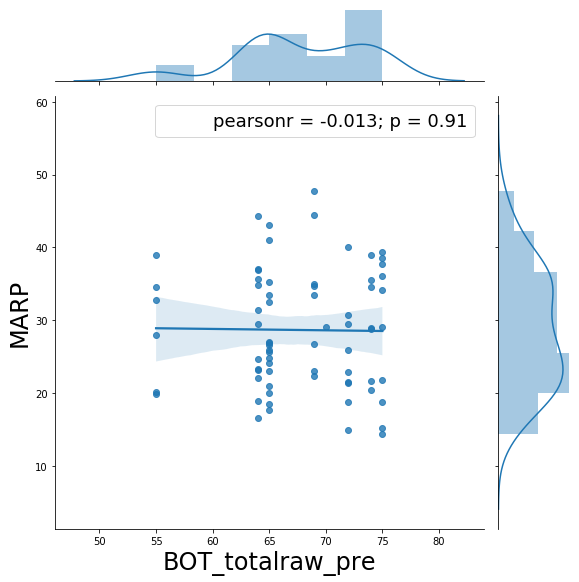

<Figure size 864x576 with 0 Axes>

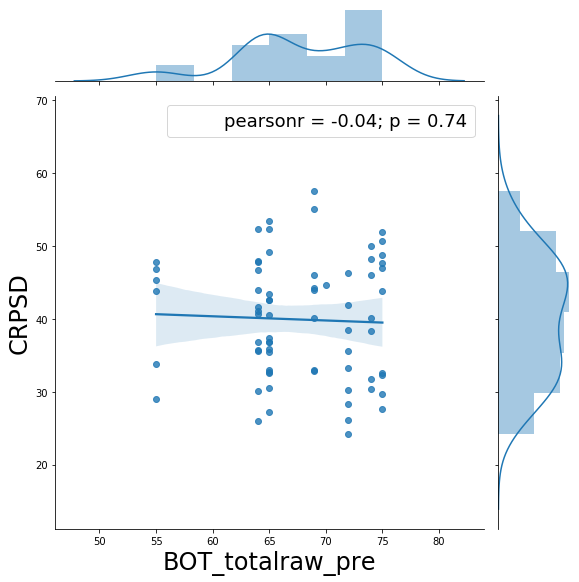

<Figure size 864x576 with 0 Axes>

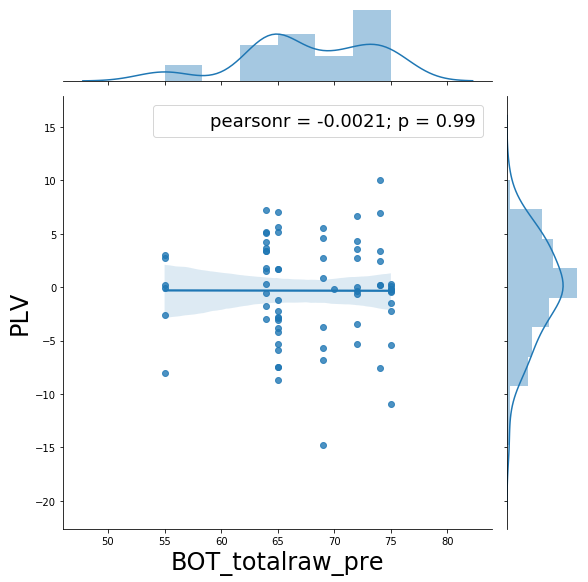

In [10]:
independent_measures = ['BOT_totalraw_pre', 'BOT_grossraw_pre', 'AGE', 'HEIGHT', 'WEIGHT']
independent_measure = 'BOT_totalraw_pre'

for cur_measure in ['MARP', 'CRPSD', 'PLV']:
    plt.figure(figsize=(12,8))

    g = sns.jointplot(x=independent_measure, y=cur_measure, data=sync_measures, kind='reg', height=8) #, hue="marker_color", col="marker_color", fit_reg=True)
    g.annotate(stats.pearsonr, fontsize=18)
    g.set_axis_labels(independent_measure, cur_measure, fontsize=24)
#     g.tick_params(labelsize=18)

    plt.show()